In [102]:
#This code takes Transmitter depth and Reciever depth and a Surface distance between the two-- specified by user --
#to throw rays from the transmitter to the reciever along paths in ice, dictated by snell's law. So inputing values for 
#depthRxm, depthTxm, and surfaceTxm in meters will out put plots of "Direct", "Refracted", and "Surface" ray paths thrown 
#from the transmitter to the reciever. Which paths that are thrown are determined by the intial angle of the path
# and the code works to find that initial angle that gives the best possible path per solution (the path that ends the 
#closest to the reciever) by using the bisecting method when testing initial angles. The plots display the ray paths that 
#got the closest to the reciever. The code always throws from the deeper depth, which is always stored in the depthRx 
#variable, but represents the transmitter. Can also take multiple sets of configurations, printing just has to be adjusted 
#to print out all relevant plots. Can also take a reciever above the ice, this is just represented by a negative sign, (-),
#in front of the depth above the ice you are interested in. 

In [317]:
#import time # if you want to see how long the code takes to run
#start_time = time.clock()
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from __future__ import print_function

In [318]:
#sourceFile = open('C:/Users/Owner/Documents/RayTracer/paperplots/rayInfo.txt', 'w')

In [360]:
#Use firn model from Arthern et al. for Greenland, Allison et al. for South Pole, 
#Kovacs et al. for conversion from density to index

#first define a few functions that will be useful.
def getDensity(thisDepth): #get density at a certain depth in feet
    thisDepth=thisDepth*0.3048 #convert feet to meters
    if southPoleFlag==0: #in Greenland
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/42)
    #n(z)=1.78-0.43e^(13.2z) z in km
    if southPoleFlag==1: #at South Pole
        nofz=1.78-0.43*np.exp(-thisDepth*0.0132)
        density=(nofz-1)/0.845
    else: #try weird stuff in the model
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/75)
    return density

def getIndex(thisDensity): #get index of refraction given some density
    ePrime=(1+0.845*thisDensity)**2
    index=np.sqrt(ePrime)        
    return index

def refractRay(index1,index2,theta1): #do refraction across some boundary
    if (np.sin(theta1)*index1/index2 > 1):
        theta2=theta1
    else:
        theta2=np.arcsin(np.sin(theta1)*index1/index2)
    return theta2

#this will propagate the ray forward for each of the three possible solutions
#-- thisInitialAngle: feed it an initial angle
#-- thisDepthRx, thisDepthTx, thisSurfaceTx: give it the configuration parameters
#-- thisStepSize: give it the total length of step you want it to make before it performs snell's law again
#-- thisNumSteps: the number of times it will iterate propagation forward
#-- whichSol: give it which solution you are looking for; "D" for directed, "R" for refracted, "S" for surface
def propagateRay(thisInitialAngle, thisDepthRx, thisDepthTx, thisSurfaceTx, thisStepSize, thisNumSteps, whichSol):
    #thisStepSize = int(thisStepSize)
    #thisNumSteps = int(thisNumSteps + (thisNumSteps*.1))
    timeOfFlight=0
    totalPath=0
    angle1=thisInitialAngle*np.pi/180 #defined from zenith down, valid to 90 degrees
    #start at the antenna down the hole, bc of the switching condition, it is always the lower of te two
    locationOfRayEnd=(0,-1*thisDepthRx) 
    rayCoordH=[] # x coordinates of path
    rayCoordV=[] # y coordinates of path
    rayCoordH.append(locationOfRayEnd[0]*0.3048) # in m
    rayCoordV.append(locationOfRayEnd[1]*0.3048) # in m
    count = 0 #variable that iterates when the ray end is first above the depth of Tx
    x=1# tells us if we are propagating forward in positive y (x = 1) or negative y (x = -1)
    surface_var = 0# variable that tells us if the ray end has broken the surface (0, hasn't...1,has)
    ayoo = 0# for "R",tells us which angle to try next if the path thrown starts propagating downward at a y below depthTx
    #for "D" tells you about horiz
    local_save= (10000000000,100000000)#saves location when ray end breaks the surface for "S", when the ray turns over for "R"
    print("thisNumSteps", thisNumSteps)
    for i in range (0,thisNumSteps + 1): # numSteps is upper bound by triangle inequality
        #PROPAGATION-----------------------------------------------------------------------------------------------
        #n1
        if(locationOfRayEnd[1] >= 0 and x> 0): #if we are above or at the surface and continuing upwards, index1 = airindex
            index1=1
        else:
            index1 = getIndex(getDensity(-1*locationOfRayEnd[1])) #else, call getIndex to get the index
        # propagate forward
        locationOfRayEnd = (locationOfRayEnd[0]+ np.sin(angle1)*thisStepSize,
                            locationOfRayEnd[1]+ x*np.cos(angle1)*thisStepSize)
        # saving each coordinate in meters
        rayCoordH.append(locationOfRayEnd[0]*0.3048)
        rayCoordV.append(locationOfRayEnd[1]*0.3048)
        totalPath=totalPath+thisStepSize #total path in ice
        timeOfFlight=timeOfFlight+thisStepSize*index1*0.3048/3e8*1e9 #in ns
        if(locationOfRayEnd[1] >= 0): #if we are at or above the surface
            index2=1 # air index
            surface_var =1
            local_save = (locationOfRayEnd[0], locationOfRayEnd[1])
            if(np.sin(angle1) > index2/index1): #if TIR condition met, theta1=theta2 and we move downward, this will be  for "S" sol
                x *=-1
                if(whichSol == "D"):
                    x = 1
                    #print("angle at surface", angle1)
                    #print(index1, index2)
                    #print("stepsize", thisStepSize)
                #    return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                #        surface_var,totalPath,timeOfFlight
                #else: 
                #print("1")
                
        else: 
            index2=getIndex(getDensity(-1*locationOfRayEnd[1]))#call getIndex for index
        angle2 = refractRay(index1,index2,angle1)
        
        #BREAKS ACCORDING TO SOLUTION---------------------------------------------------------------------------------------
        if(np.isnan(angle2)):
            print("1")
            return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                surface_var,totalPath,timeOfFlight
        if(locationOfRayEnd[0]> thisSurfaceTx):
                print("2")
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                    surface_var,totalPath,timeOfFlight 
        if(angle2 >= 89.9*np.pi/180): #bumping parameter for below surface sols
            #print("2")
            if(whichSol == "D"): #not valid for directed
                ayoo = 1
                #print("2")
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                    surface_var,totalPath,timeOfFlight
                
            else:
                x = -1 #move down
            local_save = (locationOfRayEnd[0], locationOfRayEnd[1]) 
        if(locationOfRayEnd[1] >= -1*thisDepthTx): 
            if(whichSol == "D"): # do not want "D" solutions that are above the Tx depth
                #print("3")
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo, \
                    surface_var,totalPath,timeOfFlight
            else:
                count =1
        
        #if we are plus or minus thisStepSize in the y or x around depthTx, then break
        if(locationOfRayEnd[0] <= (thisSurfaceTx + thisStepSize) and locationOfRayEnd[0] >= (thisSurfaceTx - thisStepSize) \
           and locationOfRayEnd[1] <= (-1*thisDepthTx +thisStepSize) and locationOfRayEnd[1] >= (-1*thisDepthTx - thisStepSize)):
            print("4")
            return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                surface_var,totalPath,timeOfFlight
        if(locationOfRayEnd[1] >= 200):# arbitrary, we do not want rays to propagate upwards forever
            print("5")
            return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                surface_var,totalPath,timeOfFlight
        if(whichSol == "R"):#"R" specific breaks
            #if we end below depthTx and have already been above it before and have not hit the surface, we have a valid "R"sol!
            if(locationOfRayEnd[1] < -1*thisDepthTx and count ==1 and surface_var==0):
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,\
                    surface_var,totalPath,timeOfFlight
            elif(surface_var ==1):# if we have hit or broke the surface at all, stop, we will compare this point and move accordingly
                return local_save[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                    surface_var,totalPath,timeOfFlight
            elif(local_save[0] < -1*thisDepthTx):# if the ray turns over, under depth Tx, we want to move a little differently
                ayoo = 1
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
                    surface_var,totalPath,timeOfFlight
                   
        elif(whichSol == "S"):
            #if we ae below depthTx and we've passed it before and had hit the surface, we have a valid "S" path
            if(locationOfRayEnd[1] < -1*thisDepthTx and count ==1 and surface_var ==1):
                print("here")
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,\
                    surface_var, totalPath,timeOfFlight
            

        #RESETTING ANGLE TO MOVE FORWARD ------------------------------------------------------------------
        angle1 = angle2
    print("6")
    return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,\
        surface_var,totalPath,timeOfFlight

In [361]:
#find the ray that connects the Tx and Rx, try first using "normal" refracting propagation.  Note that 
#in principle there could be 2 solutions, but this code right now only finds the first one, starting 
#from zenith down
#this code definitely works for two things below the ice, and may also work (I think it does but can't promise)
#for a tx or rx above the surface (but not both)

#the inputs:
southPoleFlag=1; #1 for South Pole, 0 for Greenland, 2 for changeable model for testing
depthRxm=[180] #depth in m of rx, positive number is below surface
surfaceTxm=[5000] #distance across surface between tx and rx in m
depthTxm=[2500] #depth in m of tx, negative number for above-surface pulser, positive for below surface
for k in range(0,len(depthRxm)): #swap tx and rx if needed so code doesn't break if Tx/Rx swapped
    if depthRxm[k]<depthTxm[k]:
        depthTxm1=depthTxm[k]
        depthTxm[k]=depthRxm[k]
        depthRxm[k]=depthTxm1

depthRx=np.zeros(len(depthRxm))
depthTx=np.zeros(len(depthTxm))
surfaceTx=np.zeros(len(surfaceTxm))

'''
   surface Tx
------------------
|                |
| depth          | depth Tx
|   Rx
|
'''

#convert to feet
for k in range(0,len(depthRxm)):
    depthRx[k]=depthRxm[k]*3.28
    surfaceTx[k]=surfaceTxm[k]*3.28
    depthTx[k]=depthTxm[k]*3.28

#iterate to propagate the ray
stepSize=5 #in feet
totalPathAll=[]
timeOfFlightAll=[]
initialAngleAll=[]
normalFlagAll=[]
timeOfFlightDirAll=[] #direct straight line ray
totalPathDirAll=[] #direct straight line ray

numSteps = 75000 # number of rays to estimate - larger is more accurate

In [346]:
for k in range(0,len(depthRx)):
    min_holder = 100000000000 # will hold the minimum rayEnd to Tx distance 
    #normalRayFlag=0 #is it a normal ray, start this flag at 0.
    end = 90.0
    start = 0.0
    stepSize = (surfaceTx[k] + abs(depthRx[k] - depthTx[k])) / numSteps # triangle inequality
    print("****Trying Direct Ray Tracing...")
    #using bisecting method to find the angle that gives us the min distance from rayEnd to Tx
    while (end - start > .00005 and start < end): 
        j = (end + start) / 2.0
        #print(start,j,end)
        # calling propagateRay ===============================================
        final_x, final_y, rayCoordH_D,rayCoordV_D, angle1, ayoo,surface_var,totalPath,timeOfFlight\
            = propagateRay(j, depthRx[k], depthTx[k], surfaceTx[k], stepSize, numSteps, "D")
        # ====================================================================
        #finding distance ft
        xdist = abs(final_x - surfaceTx[k])
        ydist = abs(final_y - (-1*depthTx[k]))
        #print(xdist, ydist)
        min_both = (xdist**2 + ydist**2) **(.5)#ft
        #save the minimum diatance and the path data associated
        #print(min_both)
        if (min_both < min_holder) :
            min_holder = min_both
            minRayCoordH_D = rayCoordH_D
            minRayCoordV_D = rayCoordV_D
            totalPathD = totalPath
            timeOfFlightD = timeOfFlight
            minFinalAngle = angle1*180/np.pi
            minInitialAngle = j
            minFinalD_x = final_x
            minFinalD_y = final_y
        #print(min_holder)
        
        #plt.figure(1)
        #ax= plt.subplot(111)
        #ax.set_ylim(ymin=-200, ymax=-50)
        #ax.set_xlim(xmin=4800, xmax=5200)
        #plt.axhline(y=0)
        #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
        #plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
        #plt.show()
        #print("final angle", 180-angle1*180/np.pi )
       # print("YEEE", final_y, (-1*depthTx[k]), surface_var)
       
        if(final_x >= surfaceTx[k]): #if rayEnd less than dist btw Rx and Tx, try a larger angle
            end = j
        elif(ayoo == 1):
            end = j
        
        #elif(surface_var == 1 and final_y < (-1*depthTx[k])):
        #    print("gearhead")
        #    end = j
        else:
            start = j
            
    #totalPathAll.append(totalPath)
    #timeOfFlightAll.append(timeOfFlight)
    #normalFlagAll.append(normalRayFlag)
    #initialAngleAll.append(j)
    
#print time.clock() - start_time, "seconds"

****Trying Direct Ray Tracing...


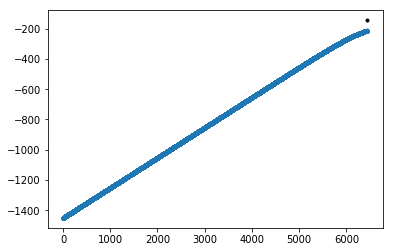

RayEnd Distance from Reciever 222.18393543845582 ft


In [311]:
#plot that best ray for Direct
plt.figure(1)
ax= plt.subplot(111)
#ax.set_ylim(ymin=0, ymax=20)
#ax.set_xlim(xmin=4000, xmax=5000)
#plt.axhline(y=0)
#plt.xlabel('Horzontal Distance [m]')
#plt.ylabel('Depth [m]')
#plt.title('ICL_D4TH_Direct')
plt.plot( minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.')
plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
#plt.savefig("C:/Users/Owner/Documents/RayTracer/paperplots/ICL_D1BV_Direct.jpg")
plt.show()
#print(min_holder)
print("IC22S_D4TH_D,","SurfaceTxm; DepthxRm; DepthTxm:",(surfaceTxm[0], depthRxm[0], depthTxm[0]), file = sourceFile)
print("--------------------------------------------------------------------------", file = sourceFile)
print("Direct", file = sourceFile)
print("Initial Angle Downhole: ", minInitialAngle, " Final Angle in Ice: ",  minFinalAngle, file = sourceFile)
print("Horizontal Distance at End: ", (minFinalD_x/3.28084), " m",file = sourceFile)
print("Depth at End: ",(minFinalD_y/3.28084),"m", file = sourceFile)
print("Time Of Flight Under Ice: ", timeOfFlightD, " ns", file = sourceFile)
print("Length of Path Under Ice: ", (totalPathD/3.28084), " m",file = sourceFile)
print("RayEnd Distance from Reciever", min_holder,"ft", file = sourceFile)
print("RayEnd Distance from Reciever", min_holder,"ft")

In [347]:
#Do all again for Refracted
for k in range(0,len(depthRx)):
    min_holder = 100000000000000
    #normalRayFlag=0 
    end = 90.0
    start = 0.0 
    stepSize = (surfaceTx[k] + abs(depthRx[k] - depthTx[k])) / numSteps 
    print("****Trying Refracted Ray Tracing...")
    while (end - start > 0.00005 and start < end): 
        j = (end + start) / 2.0
        #print(start,j,end)
        # ===============================================
        final_x, final_y, rayCoordH_R,rayCoordV_R, angle1, ayoo,surface_var,totalPath,timeOfFlight \
            = propagateRay(j, depthRx[k], depthTx[k],surfaceTx[k], stepSize, numSteps, "R")
        # ===============================================
        #mins are potential solutions, for "R" non of our potential sols should have hit the surface... though we still will
        #want to use those runs are an indicator of what angle to try next 
        if(surface_var == 0):    
            xdist = abs(final_x - surfaceTx[k])
            ydist = abs(final_y - (-1*depthTx[k]))
            min_both = (xdist**2 + ydist**2)**(.5)
            if (min_both < min_holder) :
                totalPathR = totalPath
                timeOfFlightR = timeOfFlight
                min_holder = min_both
                minRayCoordH_R = rayCoordH_R
                minRayCoordV_R = rayCoordV_R
                minFinalAngle = 180 - angle1*180/np.pi
                minInitialAngle = j
                minFinalR_x = final_x
                minFinalR_y = final_y
       
        #plt.figure(1)
        #ax= plt.subplot(111)
        #ax.set_ylim(ymin=-200, ymax=-50)
        #ax.set_xlim(xmin=4800, xmax=5200)
        #plt.axhline(y=0)
        #plt.plot( rayCoordH_R,rayCoordV_R, linestyle=":", marker='.')
        #plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
        #plt.show()
        #print("starting angle", j, "final angle",angle1*180/np.pi, "or", j)        
        #so for thosepaths that turn over, underneath the depth of Tx, they behave a bit differently than expected, we want to 
        #try a smaller angle to see if we can get more vertical propagation in the next path. Else, we want to try a larger angle
        #because that will give the horizonatal propagation we are looking for
        if (final_x > surfaceTx[k]):  
            end = j
        elif(ayoo ==1):
            end = j
        else:
            start = j
            
        #if (final_y>=-1.*depthTx[k] and final_y<-1.*depthTx[k]+5):
        #normalRayFlag=1
        #print("Ray Tracer Converged, Normal Mode")
        #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
        #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
        #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")
        #print("Depth at End: ",locationOfRayEnd[1],"ft.")
        #print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
        #print("Length of Path Under Ice: ", totalPath, " ft.")
        #else:
        #print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")
    
    #totalPathAll.append(totalPath)
    #timeOfFlightAll.append(timeOfFlight)
    #normalFlagAll.append(normalRayFlag)
    #initialAngleAll.append(j)

#print time.clock() - start_time, "seconds"
    

****Trying Refracted Ray Tracing...


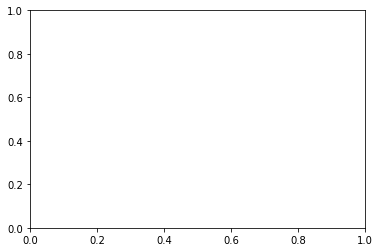

In [313]:
#Print best reflected path
plt.figure(1)
ax= plt.subplot(111)
#ax.set_ylim(ymin=-50, ymax=10)
#ax.set_xlim(xmin=1250, xmax=1600)
#plt.xlabel('Horzontal Distance [m]')
#plt.ylabel('Depth [m]')
#plt.title('IC1S_D1BV_Refracted')
#plt.axhline(y=0)
#plt.plot(minRayCoordH_R, minRayCoordV_R, linestyle=":", marker='.')
#plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
#plt.savefig("C:/Users/Owner/Documents/RayTracer/paperplots/IC1S_D1BV_Refracted.jpg")
#plt.show()
print("--------------------------------------------------------------------------", file = sourceFile)
print("Refracted", file = sourceFile)
print("Initial Angle Downhole: ", minInitialAngle, " Final Angle in Ice: ",  minFinalAngle, file = sourceFile)
print("Horizontal Distance at End: ", minFinalR_x, " m", file = sourceFile)
print("Depth at End: ",minFinalR_y,"m", file = sourceFile)
print("Time Of Flight Under Ice: ", timeOfFlightD, " ns", file = sourceFile)
print("Length of Path Under Ice: ", (totalPathD/3.28084) , " m",file = sourceFile)
print("RayEnd Distance from Reciever", min_holder,"ft", file = sourceFile)

****Trying Surface Ray Tracing...
0 45.0 90
thisNumSteps 75000
here


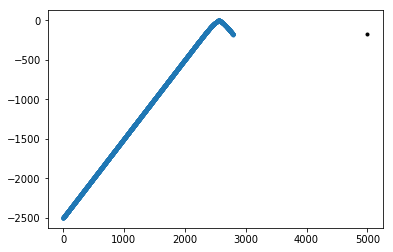

45.0 67.5 90
thisNumSteps 75000
2


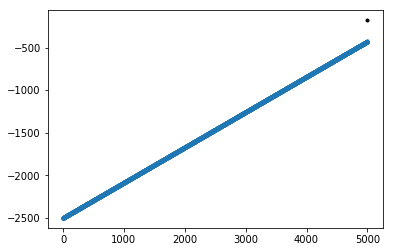

45.0 56.25 67.5
thisNumSteps 75000
2


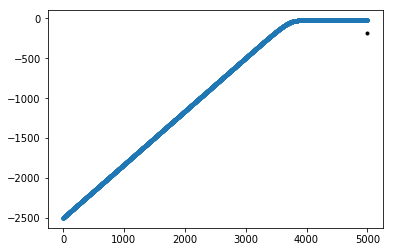

45.0 50.625 56.25
thisNumSteps 75000
here


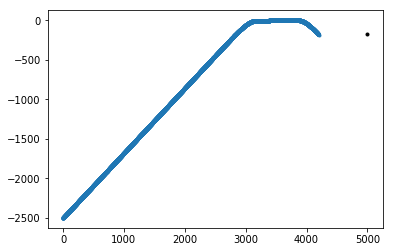

50.625 53.4375 56.25
thisNumSteps 75000
2


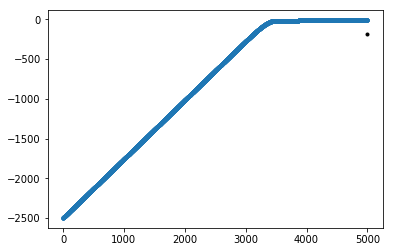

50.625 52.03125 53.4375
thisNumSteps 75000
2


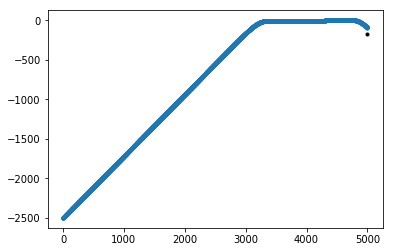

50.625 51.328125 52.03125
thisNumSteps 75000
2


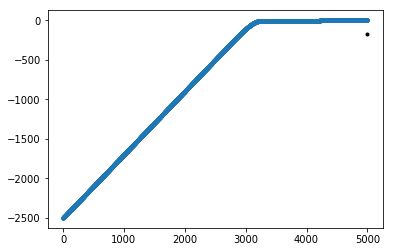

50.625 50.9765625 51.328125
thisNumSteps 75000
here


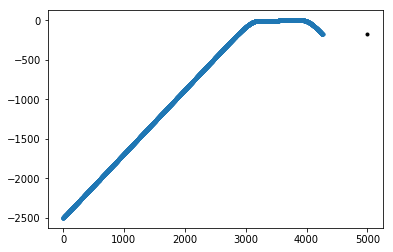

50.9765625 51.15234375 51.328125
thisNumSteps 75000
here


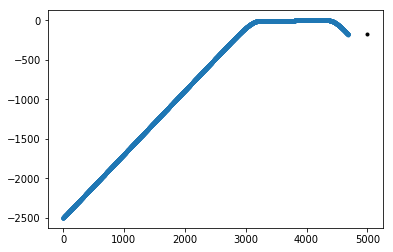

51.15234375 51.240234375 51.328125
thisNumSteps 75000
here


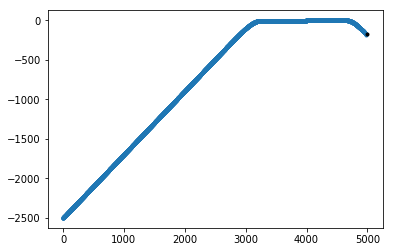

51.240234375 51.2841796875 51.328125
thisNumSteps 75000
here


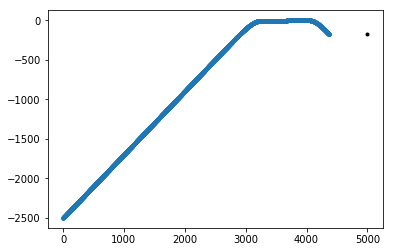

51.2841796875 51.3061523438 51.328125
thisNumSteps 75000
here


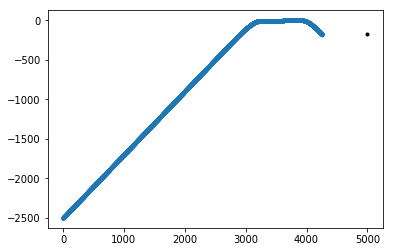

51.3061523438 51.3171386719 51.328125
thisNumSteps 75000
here


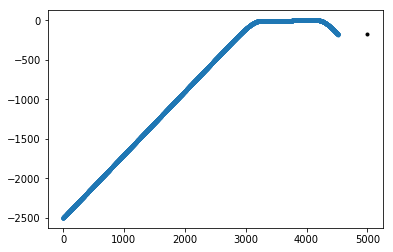

51.3171386719 51.3226318359 51.328125
thisNumSteps 75000
here


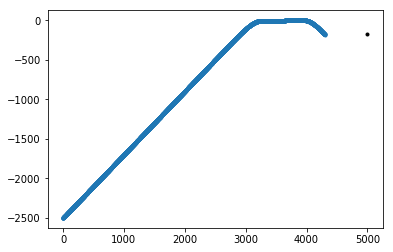

51.3226318359 51.325378418 51.328125
thisNumSteps 75000
2


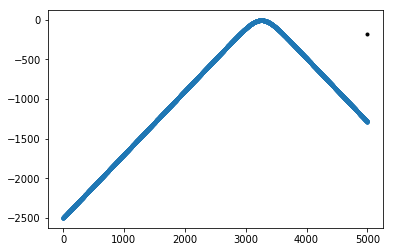

51.3226318359 51.324005127 51.325378418
thisNumSteps 75000
here


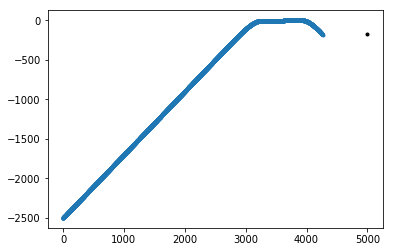

51.324005127 51.3246917725 51.325378418
thisNumSteps 75000
here


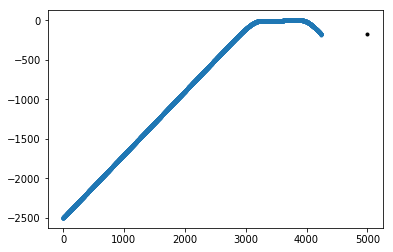

51.3246917725 51.3250350952 51.325378418
thisNumSteps 75000
2


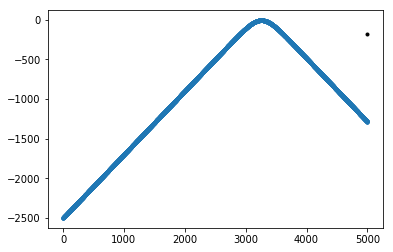

In [362]:
#Do all again for Surface solution
for k in range(0,len(depthRx)):
    print("****Trying Surface Ray Tracing...")
    min_holder =100000000000000000000000000
    minRayCoordH = []
    minRayCoordV = []
    minAngle = 0
    end = 90
    start = 0
    #numSteps = 5000
    #print("Step size:", stepSize) 
    while (end - start > .0005 and start < end): 
        j = (end + start) / 2.0
        print(start,j,end)
        #print(start,j,end)
        # ===============================================
        final_x, final_y, rayCoordH_S,rayCoordV_S, angle1, ayoo, surface_var,totalPath,timeOfFlight\
            = propagateRay(j, depthRx[k], depthTx[k],surfaceTx[k], stepSize, numSteps, "S")
        # ===============================================
        xdist = abs(final_x - surfaceTx[k])
        ydist = abs(final_y - (-1*depthTx[k]))
        min_both = (xdist**2 + ydist**2) **(.5)
        
        if(surface_var == 1): # we only want to consider those paths that hit the surface as possible "S" sols
            if (min_both < min_holder) :
                totalPathS = totalPath
                timeOfFlightS = timeOfFlight
                min_holder = min_both
                minRayCoordH_S = rayCoordH_S
                minRayCoordV_S = rayCoordV_S
                minAngle = j
        
        plt.figure(1)
        ax= plt.subplot(111)
        #ax.set_ylim(ymin=-200, ymax=-50)
        #ax.set_xlim(xmin=4800, xmax=5200)
        #plt.axhline(y=0)
        plt.plot( rayCoordH_S, rayCoordV_S, linestyle=":", marker='.')
        plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
        plt.show()

        if(final_x > surfaceTx[k]):

            end = j
        else:
            start= j

    #if (final_y>=-1.*depthTx[k] and final_y<-1.*depthTx[k]+5):
     #   normalRayFlag=1
        #print("Ray Tracer Converged, Normal Mode")
        #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
        #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
        #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")

        #print("Depth at End: ",locationOfRayEnd[1],"ft.")
        #print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
        #print("Length of Path Under Ice: ", totalPath, " ft.")
    #else:
        #print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")
        #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
        #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
        #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")
 
        #print("Depth at End: ",locationOfRayEnd[1],"ft.")
        #print("Depth at End: ",locationOfRayEnd[1]/3.3,"m")

#print time.clock() - start_time, "seconds"  

In [363]:
#collecting data for all the best paths for all three solutions
H0=minRayCoordH_D
V0=minRayCoordV_D

H1=minRayCoordH_R
V1=minRayCoordV_R

H2=minRayCoordH_S
V2=minRayCoordV_S

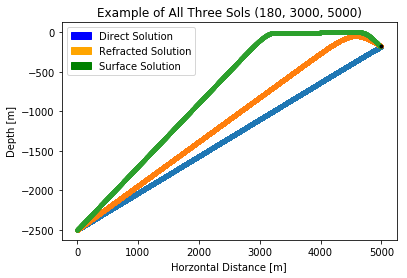

In [364]:
#plot all three
plt.figure(1)
ax= plt.subplot(111)
blue_patch = mpatches.Patch(color='blue', label='Direct Solution')
orange_patch = mpatches.Patch(color='orange', label='Refracted Solution')
green_patch = mpatches.Patch(color='green', label='Surface Solution')
plt.legend(handles=[blue_patch, orange_patch, green_patch])
#ax.set_ylim(ymin=-200, ymax=-50)
#ax.set_xlim(xmin=4800, xmax=5200)
#plt.axhline(y=0)
plt.xlabel('Horzontal Distance [m]')
plt.ylabel('Depth [m]')
plt.title('Example of All Three Sols (180, 3000, 5000)')
plt.plot(H0,V0, linestyle=":", marker='.')
plt.plot(H1,V1, linestyle=":", marker='.')
plt.plot( H2,V2, linestyle=":", marker='.')
plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
plt.savefig("C:/Users/Owner/Documents/RayTracer/paperplots/Example of All Three Sols (180, 3000, 5000)")
plt.show()
#print("--------------------------------------------------------------------------", file = sourceFile)
#print("Times of Flight, ns:", "\n", "Direct:", timeOfFlightD, "Refracted:", timeOfFlightR, file = sourceFile)
#print("Delta t in ns, btw Direct and Refracted:", abs(timeOfFlightD -timeOfFlightR), end = '\n', file = sourceFile)
#print time.clock() - start_time, "seconds"

sourceFile.close()

In [316]:
sourceFile.close()